# Preprocesado de datos para clustering

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
__INTERIM_DATA_PATH__ = "../data/interim"
__PROCESSED_DATA_PATH__ = "../data/processed"

__OUTPUT_DF_NAME__ = "easy_money_processed"

## Classes

In [43]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''

    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.index is not None:
            df = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            df = pd.DataFrame(X, columns=self.columns)
        return df


class FeatureGenerator(BaseEstimator, TransformerMixin):
    """
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    """

    def __init__(self, index: str):
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        index = self.index if self.index else X.index
        return X.groupby(index).agg(
            # active_customer
            active_customer_mean=("active_customer", np.mean),
            active_customer_last=("active_customer", self.__get_last_value),

            # salary
            salary_mean=("salary", np.mean),
            salary_last=("salary", self.__get_last_value),

            # age
            age_mean=("age", np.mean),
            age_last=("age", self.__get_last_value),

            # short_term_deposit
            short_term_deposit=("short_term_deposit", np.mean),

            # em accounts
            emc_account=("emc_account", np.mean),
            em_account_p=("em_account_p", np.mean),
            em_acount=("em_acount", np.mean),

            # gender
            gender=("gender", pd.Series.mode)
        )

    def __get_last_value(self, serie: pd.Series):
        return serie.iloc[-1]


class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''

    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''

        # lista vacía
        criteria_list = []

        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q=self.q)
            criteria_list.append(criteria)

        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:

            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]

            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria

        else:
            global_criteria = criteria_list[0]

        # filtramos nuestra dataframe
        X = X[global_criteria]

        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index

        return X

In [44]:
def generate_clusters(dataframe: pd.DataFrame, min_cluster: int = 2, max_cluster: int = 10):
    st = time.time()
    sse = {}
    for k in range(min_cluster, max_cluster):
        print(f"Fitting pipe with {k} clusters")
        _clustering_model = KMeans(n_clusters=k)
        _clustering_model.fit(dataframe)
        sse[k] = _clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st) / 60), 2))

    return sse


def plot_elbow(sse):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label="Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize=16)

## Import data

In [5]:
df = pd.read_csv(f"{__INTERIM_DATA_PATH__}/easy_money_prep_1.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.shape

(5962838, 144)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,5962838.0,1.234933e+06,162293.085772,15891.0,1112533.0,1231097.0,1352339.75,1553689.0
active_customer,5962838.0,4.033799e-01,0.490576,0.0,0.0,0.0,1.00,1.0
region_code,5962838.0,2.580417e+01,13.603136,-1.0,13.0,28.0,36.00,52.0
gender,5962838.0,5.177870e-01,0.499684,0.0,0.0,1.0,1.00,1.0
age,5962838.0,2.976015e+01,11.980074,2.0,22.0,25.0,34.00,105.0
...,...,...,...,...,...,...,...,...
country_id_SA,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_SE,5962838.0,2.683286e-06,0.001638,0.0,0.0,0.0,0.00,1.0
country_id_SN,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_US,5962838.0,3.270255e-05,0.005719,0.0,0.0,0.0,0.00,1.0


## Experimentation

In [67]:
pipe = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    # ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary_mean", "salary_last"])),
])

In [68]:
result_pipe1_df = pipe.fit_transform(df)
result_pipe1_df

,active_customer_mean,active_customer_last,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,em_acount,gender
pk_cid,,,,,,,,,,,
15891,0.500000,0,73136.475,73136.475,59.000000,59,0.0,0.000000,0.0,0.500000,1
16063,0.714286,0,117492.510,117492.510,62.000000,62,0.0,0.000000,0.0,0.000000,1
16203,0.833333,1,83697.150,83697.150,70.000000,70,0.0,0.000000,0.0,0.833333,0
16502,0.888889,1,126428.730,126428.730,57.888889,58,0.0,0.555556,0.0,0.888889,1
17457,1.000000,1,102405.750,102405.750,53.117647,54,0.0,0.000000,0.0,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000000,0,115653.195,115653.195,52.000000,52,0.0,0.000000,0.0,0.000000,0
1553686,0.000000,0,119694.045,119694.045,30.000000,30,0.0,0.000000,0.0,0.000000,1
1553687,0.000000,0,101198.115,101198.115,21.000000,21,0.0,0.000000,0.0,0.000000,0


In [69]:
pipe2 = Pipeline(steps=[
    ("Scale", MinMaxScaler()),
    ("array_to_dataframe", ArrayToDataFrame(index=result_pipe1_df.index, columns=result_pipe1_df.columns))
])

In [70]:
processed_df = pipe2.fit_transform(result_pipe1_df)
processed_df.head(10)

,active_customer_mean,active_customer_last,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,em_acount,gender
pk_cid,,,,,,,,,,,
15891,0.250660,-0.778788,-0.263706,-0.263706,2.339802,2.304523,-0.099802,-0.234620,-0.002093,-0.378263,0.975545
16063,0.713566,-0.778788,-0.004981,-0.004981,2.582968,2.547734,-0.099802,-0.234620,-0.002093,-1.500064,0.975545
16203,0.970737,1.284047,-0.202107,-0.202107,3.231409,3.196297,-0.099802,-0.234620,-0.002093,0.369604,-1.025068
16502,1.090750,1.284047,0.047143,0.047143,2.249741,2.223453,-0.099802,2.613457,-0.002093,0.494248,0.975545
17457,1.330775,1.284047,-0.092981,-0.092981,1.863008,1.899171,-0.099802,-0.234620,-0.002093,0.743537,0.975545
17590,1.330775,1.284047,1.685330,1.685330,1.993476,1.980242,-0.099802,-0.234620,-0.002093,-1.500064,-1.025068
17799,1.330775,1.284047,-0.197354,-0.197354,1.309926,1.331679,-0.099802,-0.234620,-0.002093,0.743537,0.975545
17970,1.330775,1.284047,-0.135586,-0.135586,3.650988,3.682719,-0.099802,4.891919,-0.002093,-1.500064,-1.025068
17980,1.330775,1.284047,0.957270,0.957270,3.817500,3.844860,-0.099802,-0.234620,-0.002093,-1.500064,-1.025068


In [71]:
sse = generate_clusters(processed_df, 2, 12)

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Elbow curve took 1 minutes.


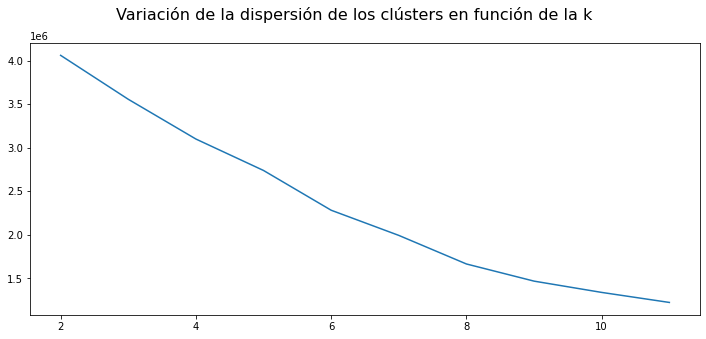

In [72]:
plot_elbow(sse)

## Processing

In [53]:
pipeline = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    ("OutlierFilter", OutlierFilter(q=0.90, col_to_filter=["salary_mean", "salary_last"])),
    ("Scale", MinMaxScaler()),
    ("Clustering", KMeans(n_clusters=6))
])

In [54]:
%%time
processed_df = pipeline.fit(df)
X_processed = pipeline["FeatureGenerator"].transform(df)
X_scaled = pipeline["Scale"].transform(X_processed)

print(f"""
X_scaled.shape:    {X_scaled.shape}
X_processed.shape: {X_processed.shape}
""")

labels = pipeline["Clustering"].predict(X_scaled)
X_processed["cluster"] = labels


X_scaled.shape:    (456371, 11)
X_processed.shape: (456371, 11)

Wall time: 1min 53s


## Results observation

In [66]:
clustering_result = X_processed.copy(deep=True)
clustering_result

,active_customer_mean,active_customer_last,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,em_acount,gender,cluster
pk_cid,,,,,,,,,,,,
15891,0.500000,0,73136.475,73136.475,59.000000,59,0.0,0.000000,0.0,0.500000,1,4
16063,0.714286,0,117492.510,117492.510,62.000000,62,0.0,0.000000,0.0,0.000000,1,4
16203,0.833333,1,83697.150,83697.150,70.000000,70,0.0,0.000000,0.0,0.833333,0,1
16502,0.888889,1,126428.730,126428.730,57.888889,58,0.0,0.555556,0.0,0.888889,1,3
17457,1.000000,1,102405.750,102405.750,53.117647,54,0.0,0.000000,0.0,1.000000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000000,0,115653.195,115653.195,52.000000,52,0.0,0.000000,0.0,0.000000,0,2
1553686,0.000000,0,119694.045,119694.045,30.000000,30,0.0,0.000000,0.0,0.000000,1,4
1553687,0.000000,0,101198.115,101198.115,21.000000,21,0.0,0.000000,0.0,0.000000,0,2


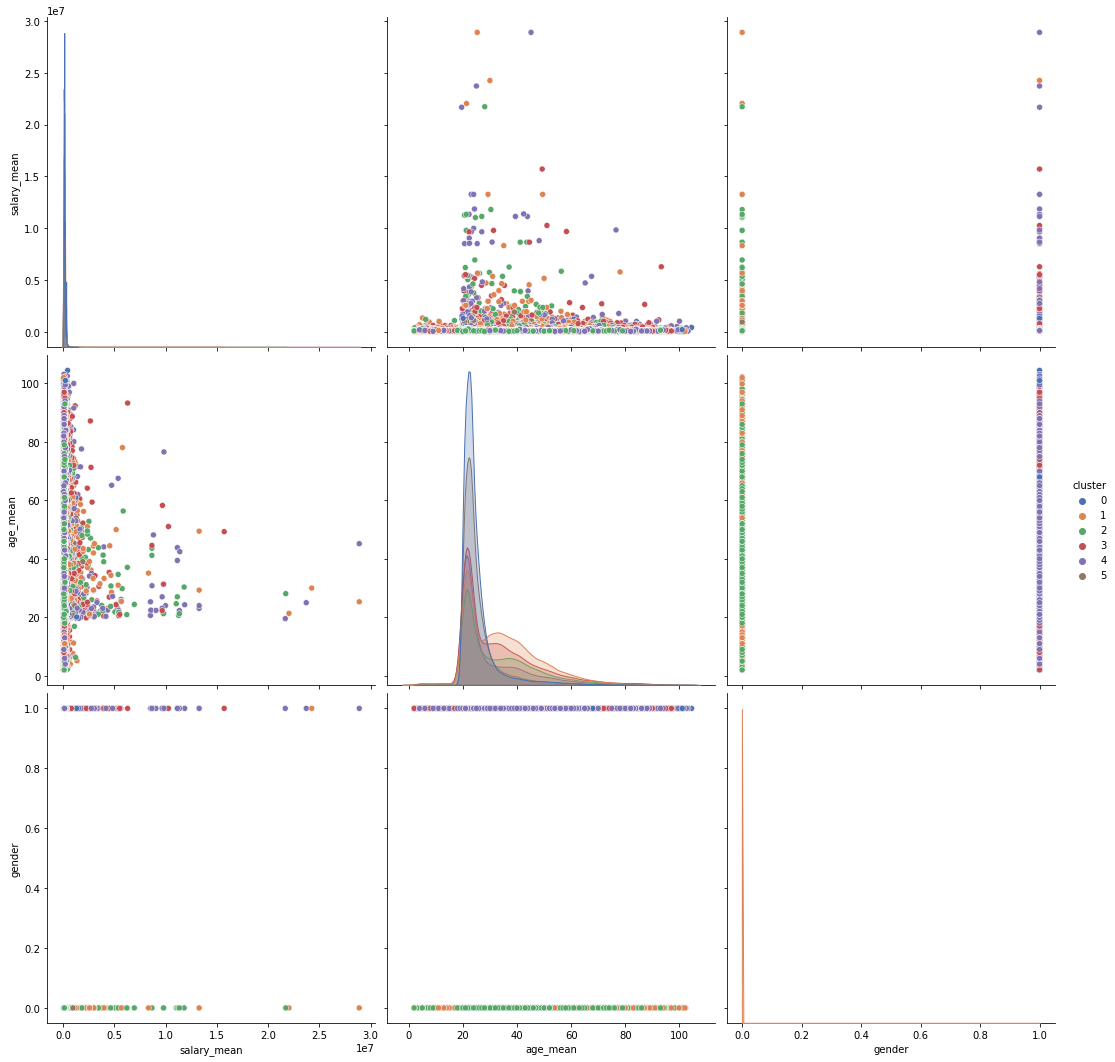

In [60]:
sns.pairplot(clustering_result, vars=["salary_mean", "age_mean", "active_customer_mean"], hue="cluster", height=5,
             palette="deep")

<AxesSubplot:xlabel='age_mean', ylabel='salary_mean'>

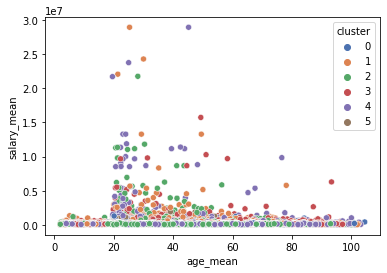

In [57]:
sns.scatterplot(data=clustering_result, x="age_mean", y="salary_mean", hue="cluster", palette="deep")

In [75]:
cluster_gb = clustering_result.groupby("cluster")

cluster_report = cluster_gb.agg(
    # active_customer
    active_customer_mean=("active_customer_mean", np.mean),

    # salary
    # salary_min=("salary_mean", np.min),
    salary_mean=("salary_mean", np.mean),
    # salary_max=("salary_mean", np.max),

    # age
    age_mean=("age_mean", np.mean),

    # short_term_deposit
    short_term_deposit=("short_term_deposit", np.mean),

    # em accounts
    emc_account=("emc_account", np.mean),
    em_account_p=("em_account_p", np.mean),
    em_acount=("em_acount", np.mean),

    # gender
    gender=("gender", np.mean)
)
cluster_report.to_csv(f"{__PROCESSED_DATA_PATH__}/cluster_df.csv")

cluster_size = cluster_gb.size().to_frame()
cluster_size.columns = ["cluster_size"]

cluster_report = cluster_size.T.append(cluster_report.T)

In [76]:
cluster_report.style.background_gradient(cmap='BuGn', axis=1)

cluster,0,1,2,3,4,5
cluster_size,93733.000000,89607.000000,58519.000000,82365.000000,57735.000000,74412.000000
active_customer_mean,0.052660,0.936837,0.033879,0.941256,0.027639,0.070461
salary_mean,110577.588461,117459.610275,125947.131661,117685.167367,130263.157191,114709.459427
age_mean,25.182380,34.618827,32.908848,32.763861,30.118168,25.884895
short_term_deposit,0.000825,0.004798,0.003708,0.003854,0.002875,0.001381
emc_account,0.003699,0.113294,0.026302,0.088668,0.017047,0.007539
em_account_p,0.000000,0.000011,0.000000,0.000012,0.000000,0.000000
em_acount,0.986475,0.791181,0.024514,0.804146,0.020443,0.979939
gender,1.000000,0.000011,0.000000,1.000000,1.000000,0.000000
